# Imports

In [1]:
import numpy as np
import pyquasar as pq

# Helmholtz equation with fixed frequency

$\Delta p + k^2 p = -j \rho_0 \omega q$

Dirichlet boundary condition:

$p = \hat p$

Neumann boundary condition:

$\nu_n = \frac{j}{\rho_0 \omega} \frac{\partial p}{\partial n} = \hat \nu_n$

Robin boundary condition:

$p = Z \nu_n = \frac{j}{\rho_0 \omega A} \frac{\partial p}{\partial n}$ 

where:
 - $\omega = 2 \pi f$;
 - $k = \frac{\omega}{c}$;
 - $c$ -- speed of sound;
 - $f$ -- frequency;
 - $\rho_0$ -- density;
 - $Z$ -- impedance;
 - $A$ -- ???;
 - $\nu_n$ -- normal velocity.

## Robin boundary condition

$a u + b \frac{\partial u}{\partial n} = g$

$\frac{\partial u}{\partial n} + \frac{a}{b} u = \frac{g}{b}$

$\lambda \frac{\partial u}{\partial n} + \beta (u - u_{\beta}) = 0$

$\lambda \frac{\partial u}{\partial n} + \beta u = \beta u_{\beta}$


$p = \frac{j}{\rho_0 \omega A} \frac{\partial p}{\partial n}$

$\frac{\partial p}{\partial n} - \frac{\rho_0 \omega A}{j} p = 0$

In [2]:
air = {"density": 1.21, "speed": 343, "impedance": 415} 

In [617]:
f = 300
k = 2 * np.pi * f / air["speed"]
j = 1.j

In [618]:
def u(p, n):
  return np.zeros_like(p[..., 0])

def source(p, n):
  return j * air["density"] * 2 * np.pi * f * 0.25 * np.ones_like(p[..., 0])

def flow(p, n):
  return np.zeros_like(p[..., 0])

def ub(p, n):
  return 2 * (n[..., 0] - n[..., 1]) + p[..., 0] - p[..., 1]

In [636]:
mesh = pq.Mesh.load("cube.geo", refine_k=2)
domains = [pq.FemDomain(domain) for domain in mesh]
problem = pq.FemProblem(domains)

In [637]:
mesh

<Mesh object summary 
	Numeration: global
	Domains: [<MeshDomain object summary
	Material: air
	Total elements number: 75200
	Element type: Tetrahedron 4; Count: 75200
	Boundary type: source; Tag: 7; Element type: Triangle 3; Count: 1056.
	Boundary type: neumann; Tag: 8; Element type: Triangle 3; Count: 800.
	Boundary type: neumann; Tag: 9; Element type: Triangle 3; Count: 1024.
	Boundary type: neumann; Tag: 10; Element type: Triangle 3; Count: 544.
	Boundary type: neumann; Tag: 11; Element type: Triangle 3; Count: 1024.
	Boundary type: neumann; Tag: 12; Element type: Triangle 3; Count: 544.
	Boundary type: neumann; Tag: 13; Element type: Triangle 3; Count: 800.
>]>

In [653]:
materials = {"air": {"source":{"source": source}, "gamma": -k**2}}
problem.assembly(materials, dtype=np.complex128)

In [654]:
problem.add_skeleton_projection(u, ["neumann"], dtype=np.complex128)

In [ ]:
problem._matrix = 

In [655]:
problem.factorize()

TypeError: must be a CSC/CSR matrix (is <class 'scipy.sparse._csc.csc_array'>)

In [640]:
sol = problem.solve(1e-12)

In [641]:
def fundamental(p, n):
  norm = np.linalg.norm(p - np.array([[1.25, 1, 1.25]]), axis=1)
  return - np.exp(j * k * norm) / (4 * np.pi * norm)

In [642]:
fund = fundamental(problem.domains[0].vertices, 0)

In [643]:
pts = np.linspace(1, 2.75, 200)

In [644]:
pts = pts + 1.25
pts = np.concatenate([pts[:, None], np.ones_like(pts)[:, None], 1.25 * np.ones_like(pts)[:, None]], axis=1)

In [645]:
fund = fundamental(pts, 0)
fund *= -j * air["density"] * 2 * np.pi * f

In [646]:
fund_real = fund.real
fund_imag = fund.imag

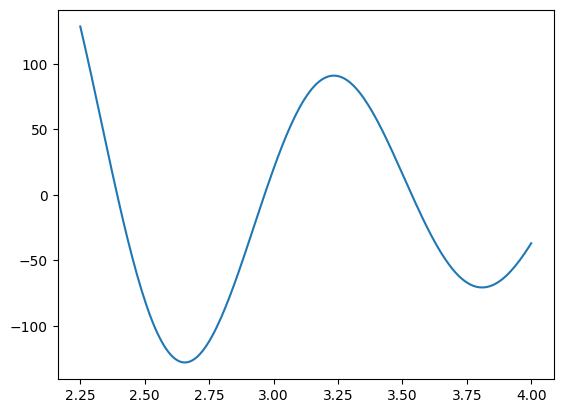

In [647]:
graph = plt.plot(pts[:, 0], fund_real)

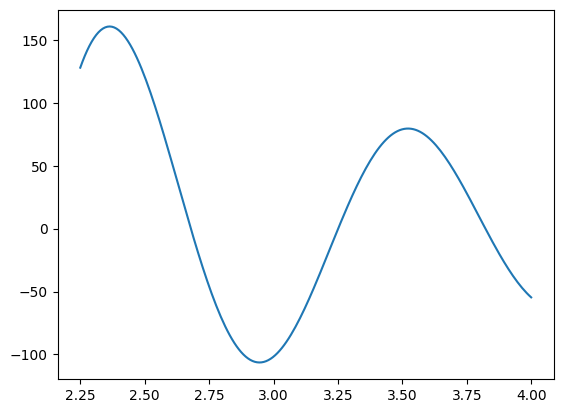

In [648]:
graph2 = plt.plot(pts[:, 0], fund_imag)

In [649]:
test_proj = problem.tabulate(pts, batch_size=256)
measures = test_proj @ sol

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


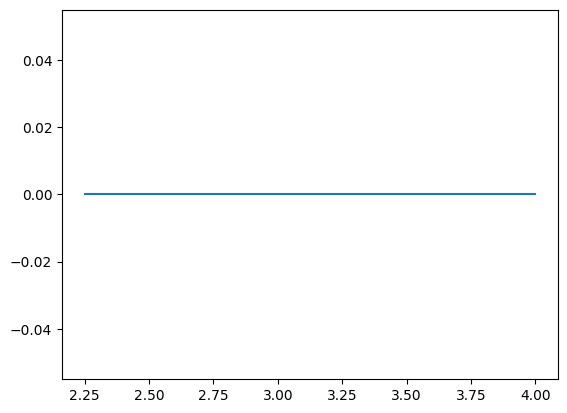

In [650]:
plt.plot(pts[:, 0], measures.real)

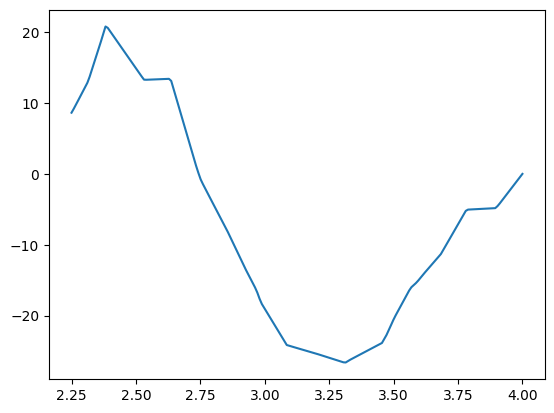

In [651]:
plt.plot(pts[:, 0], measures.imag)

In [333]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [334]:
xs = np.linspace(0, 4, 50)
zs = np.linspace(0, 3, 50)

In [335]:
x, z = np.meshgrid(xs, zs)
x = x.flatten()
z = z.flatten()

In [360]:
points = np.concatenate([x[:, None], 1.01 * np.ones_like(x)[:, None], z[:, None]], axis=1)

In [361]:
pts_proj = problem.tabulate(points, batch_size=512)
pts_proj

100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


<2500x13783 sparse array of type '<class 'numpy.float64'>'
	with 9828 stored elements in Compressed Sparse Row format>

In [362]:
test_sol = pts_proj @ real_sol

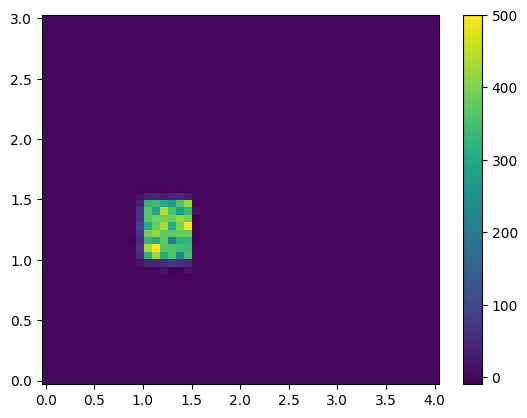

In [363]:
fig, ax = plt.subplots()
ctr = ax.pcolor(xs, zs, test_sol.reshape(50, 50))
fig.colorbar(ctr)
plt.show()